### Non-ideal reaction-diffusion systems

In the last notebook you learned the basics of phase separation driven by the competition between entropy (favoring mixing) and non-ideal interactions (favoring demixing). In this notebook you will see how first order reactions can introduce patterns of a certain length scale.

In [3]:
''' Import the packages that we need for this tutorial '''
import sys          # sys allows us to add paths to packages
import numpy as np  # numpy 
import matplotlib.pyplot as plt

import pde

We build upon the last notebook, where the concentration field $c(x,y,t)$ describes the state of the system. But now the dynamics are not given by diffusion only, instead the particles can react as well and we introduce a reactive flux $s$ that describes how many $A$ particles are created $s>0$ or destroyed $s<0$ per unit time. In this case the full dynamics are given by

\begin{align}
    \partial_t c(x,y,t) = M\nabla^2 \mu (x,y,t) + s(x,y,t)
\end{align}

where we assume a constant diffusive mobility $M$.

We assume a simple switch between the two particle types $A\rightleftharpoons B$, where $A\rightarrow B$ proceeds with rate $k_f$ and $B\rightarrow A$ with rate $k_b$. The total change of $A$ particles is then given by $s=-k_fc_A + k_bc_B=-k_fc+k_b(1-c)$, using $c_A=c$ and $c_B=1-c_A$. 

### Reactions in a homogeneous mixture

We neglect diffusion for now and discuss the reactive flux $s$ only.

### Problem 1

For constant $k_f$ and $k_b$, calculate the concentration $c_0$ for which $s(c)=-k_f c+k_b(1-c)$ vanishes. Afterwards plot $s(c)$ for $k_f=1$ and $k_b=0.3k_f$. For a given $c(t=0)$ and use it to explain the dynamics $\partial_t c = -k_f c + k_b(1-c)$.<br>
Then determine the slope $-k$ in terms of $k_f$ and $k_b$ and express $s(c)$ in terms of $k$ and $c_0$.

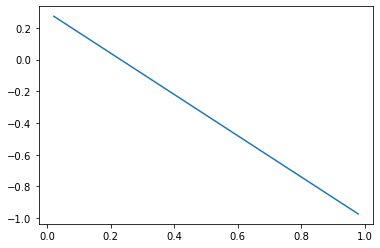

In [4]:
kf = 1
kb = 0.3*kf
c = np.linspace(0, 1)[1:-1]

plt.plot(c,-kf*c+kb*(1-c))

### Solution 1

For $c>c_0$ $s<0$ so $A$ gets destroyed until $c=c_0$, while $A$ is created for $c<c_0$, so $c_0$ is a stable fixpoint.<br>
The slope is $k=k_f+k_b$ and the flux vanishes for $c_0=k_b/(k_f+k_b)$, so $s(c) = -k(c-c_0)$.

### Combining non-ideal diffusion and reaction

We use the free energy density from the last tutorial

\begin{align}
    F = a V \phi^2 ( 1- \phi^2)
\end{align}

which is plotted below for $a=1$.

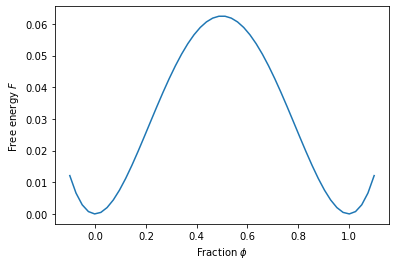

In [8]:
c = np.linspace(-0.1, 1.1)
plt.plot(c, c**2 * (1 - c)**2)
plt.xlabel('Fraction $\phi$')
plt.ylabel(r'Free energy $F$');

### Problem 2

First adjust the `pde.PDE` to include chemical reactions $s(c)=-k(c-c_0)$.<br>
Then run the simulation for $k=5\cdot10^{-3}$ and $c_0=0.1$. How does the average concentration develop over time? Why is it different from the case without reactions?

Afterwards find a function that describes the average concentratoin over time $\bar{c}(t)$ using the initial average concentration $\bar{c}(t=0)$ and the reaction parameters $k$ and $c_0$.

In [102]:
# define the partial differential equation
k = 5.e-3
c0 = 0.1

eq = pde.PDE({'c': 'laplace(2 * c * (1 - c) * (1 - 2*c) - laplace(c))'})

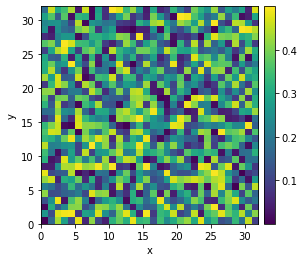

  0%|          | 0/1000.0 [00:00<?, ?it/s]

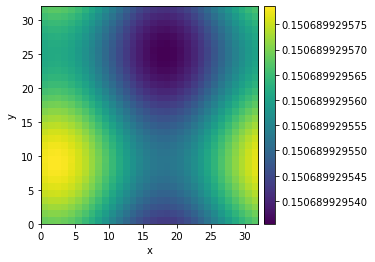

In [103]:
# prepare a random initial state
grid = pde.UnitGrid([32, 32], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=0.5)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=1000, dt=1.e-3, tracker=['progress', storage.tracker(10)])
final_state.plot();

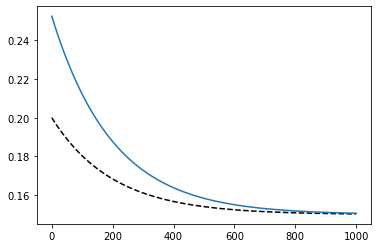

In [104]:
avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)
plt.plot(ts,0.15+(0.2-0.15)*np.exp(-k*ts),ls='--',color='k')
plt.plot(ts,avs)
plt.show()
plt.close()

### Solution

The average concentration decays exponetially towards $c_0$. Mass is not conserved anymore.
The average concentration can be described by $\bar{c}(t)=c_0+(\bar{c}(t=0)-c_0)\exp(-kt)$

In [93]:
eq2 = pde.PDE({'c': f'laplace(2 * c * (1 - c) * (1 - 2*c) - 2*laplace(c)) - {k} * (c - {c0})'})
eq2.expressions

{'c': '-0.005*c + laplace(2*c*(c - 1)*(2*c - 1) - 2*laplace(c)) + 0.00075'}

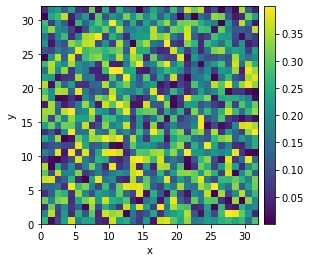

  0%|          | 0/1000.0 [00:00<?, ?it/s]

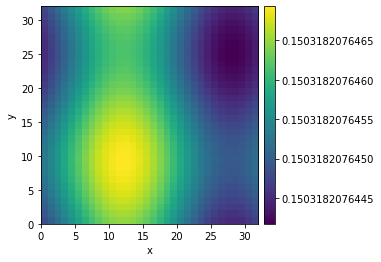

In [94]:
# prepare a random initial state
grid = pde.UnitGrid([32, 32], periodic=True)
initial_state = pde.ScalarField.random_uniform(grid, vmin=0, vmax=0.4)
initial_state.plot();

# simulate the dynamics
storage = pde.MemoryStorage()
final_state = eq2.solve(initial_state, t_range=1000, dt=1.e-3, tracker=['progress', storage.tracker(10)])
final_state.plot();

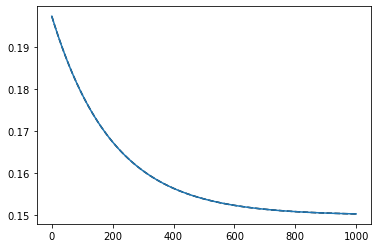

In [96]:
avs = np.zeros(len(storage.data))
for i in range(len(storage.data)):
    avs[i] = np.average(storage.data[i])
ts = np.asarray(storage.times)
plt.plot(ts,c0+(avs[0]-c0)*np.exp(-k*ts),ls='--',color='k')
plt.plot(ts,avs)